Segmentation de tumeurs par YOLOv8 sur la database MICCAI

_______________________________________________________________________________________________________________________________________________________________

1) __Intro__ : 

Nous souhaitons créer un model YOLOv8 à la segmentation d'images MICCAI. Pour cela nous avons utilisé la database MICCAI. Npus partons donc de données compressées sous formats '.nii'. Cette data est composé de scans 3D cérébraux de 393 patients. Chaque scan est décomposé en 2 fichier '.nii' correspondant à la vérité de terrain (scan 3D segmenté à la main en plusieurs labels => niveau de gris entre 0 et 5) et au cliché à proprement parlé (coupe du cerveau dans les 3 axes).

YOLOv8 est un réseau neuronal profond édité par Ultralytics. Toute la doc peut être directement retrouvez sur le site : https://docs.ultralytics.com/tasks/detect/

La biblithéque implementant YOLOv8 est sur : https://github.com/ultralytics/ultralytics 

Le l'environnement correspondant ce jupyter est présent sur le github suivant : https://github.com/ElMagicarp/PIR_3_YOLO/tree/main/Brats_with_YOLOv8

__ATTENTION__ : nous utilisons ici Pytorch en mode 'cpu' pour faire tourner le réseau

_______________________________________________________________________________________________________________________________________________________________

__Préparation des imports / pip__

In [7]:
import os
import sys
os.system("pip uninstall -y nvidia_cublas_cu11")


0

In [8]:
'''def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            
            lenIntersection=0
            
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1
             
            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value'''

'def dice_coef(img, img2):\n        if img.shape != img2.shape:\n            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")\n        else:\n            \n            lenIntersection=0\n            \n            for i in range(img.shape[0]):\n                for j in range(img.shape[1]):\n                    if ( np.array_equal(img[i][j],img2[i][j]) ):\n                        lenIntersection+=1\n             \n            lenimg=img.shape[0]*img.shape[1]\n            lenimg2=img2.shape[0]*img2.shape[1]  \n            value = (2. * lenIntersection  / (lenimg + lenimg2))\n        return value'

In [9]:
import yoloTools
import SLICER as slc
import FORMATAGE as frm

from picsellia.types.enums import AnnotationFileType

from ultralytics import YOLO #execute in terminal "pip uninstall -y nvidia_cublas_cu11" if issue with Cublas
import numpy as np

import cv2
from matplotlib import pyplot as plt
import os
import sys
from PIL import Image
from matplotlib import pyplot as plt
import glob
import torch
sep = os.path.sep

_______________________________________________________________________________________________________________________________________________________________

2) __Formatage de la database__ :

Dans cette implementation, nous utiliserons le formatage en répertoires suivant (contrainte ultralytics + yolotools):

```
-- datasets  +-- raw  +-- test  +-- images
             |        |         |
             |        |         +-- labels
             |        |
             |        +-- train +-- images
             |        |         |
             |        |         +-- labels
             |        |
             |        +-- val   +-- images
             |                  |
             |                  +-- labels
             |
             +-- refined  +-- test  +-- images
                          |         |
                          |         +-- labels
                          |
                          +-- train +-- images
                          |         |
                          |         +-- labels
                          |
                          +-- val   +-- images
                                    |
                                    +-- labels
```

__Pour constituer le dataset :__
 1) Télécharger l'archive MICCAI
 2) Extraire l'archive dans le répertoire datasets
 3) Déplacer tout les fichiers compressés .nii.gz dans répertoire datasets
 
 4) Executer les scripts suivants ce markdown jusqu'à la prochaine section

__a) déclaration des config d'extraction des données (slice en png et réparti dans les bons fichiers)__

In [10]:
path_vers_datasets_raw = f'..{sep}datasets{sep}raw' #chemin relatif vers le répertoire dataset/raw
seuil = 1 #seuil disciminant pour la sélection des coupes (int entre 1 et 100 => rapport nb pixels segementés/nb pixels)
nb_coupe_par_scan = 5 #nb de coupes max extraites par fichier .nii.gz
#print(os.path.isdir("../datasets/raw/test")) 

__facultatif) test du dataset pour connaitre seuil max pour un nb de coupes par scan__

__b) slice(.nii.gz -> png) + distribution dans les bons répertoires (refined/..) avec la répartition suivante:__

train = 64% dataset ; val = 16% dataset ; test = 20% dataset

Rq :  les patients ne peuvent être présent que dans un seul des sous répertoires

In [11]:
print('#_____________SELECTION_____________#')
slc.slicer_main(path_vers_datasets_raw, seuil, nb_coupe_par_scan)

#_____________SELECTION_____________#
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code


NameError: name 'exit' is not defined

__d) déclaration des config pour le formatage des données__

__ATTENTION__ : à cause de cv2, la segmentation ne se fait qu'en binaire, on ramene alors touts les labels à la même valeur ce qui nous empêche de les différencier

__ATTENTION__ : si vous souhaitez changer de format ('bbox' ou 'seg') aprés avoir déjà formaté le dataset, vous devez repartir de la commande 2.b) en modifiant la variable 'mode' de 2.d) 

In [19]:
path_vers_datasets_refined = f'..{sep}datasets{sep}refined' #chemin relatif vers le répertoire dataset/refined
mode = 'seg' #indique le format souhaité 'seg' ou 'bbox' => 'bbox' pour bounding box et 'seg' pour segmentation
resize = 128 # résolution de l'image carrée de sortie => reformatage en image carrée multiple de 32 à cause de YOLOv8 (ou changer 1ére couche du réseau)

__c) formatage du dataset avec génération du json format COCO et des data.yaml__

In [4]:
frm.formatage_main(path_vers_datasets_refined,mode,resize)

rm: cannot remove '/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/labels/*.txt': No such file or directory
rm: cannot remove '/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/val/labels/*.txt': No such file or directory
rm: cannot remove '/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/test/labels/*.txt': No such file or directory


Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/labels/MICCAI_Patient_6_e260.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/images/MICCAI_Patient_6_e260.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/labels/MICCAI_Patient_1_e248.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/images/MICCAI_Patient_1_e248.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/labels/MICCAI_Patient_1_e241.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/images/MICCAI_Patient_1_e241.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/labels/MICCAI_Patient_6_e218.png
Rescaling image: /home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/../datasets/refined/train/images/MICCAI_Pat

100%|██████████| 40/40 [00:00<00:00, 12878.80it/s]


MICCAI_Patient_6_e260.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_1_e248.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_1_e241.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_6_e218.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_1_e250.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_3_e244.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_6_e258.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_3_e219.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_3_e258.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/train/labels
MICCAI_Patient_6_e219.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/r

100%|██████████| 40/40 [00:00<00:00, 17829.13it/s]


MICCAI_Patient_6_e260.png
MICCAI_Patient_1_e248.png
MICCAI_Patient_1_e241.png
MICCAI_Patient_6_e218.png
MICCAI_Patient_1_e250.png
MICCAI_Patient_3_e244.png
MICCAI_Patient_6_e258.png
MICCAI_Patient_3_e219.png
MICCAI_Patient_3_e258.png
MICCAI_Patient_6_e219.png
MICCAI_Patient_6_e259.png
MICCAI_Patient_3_e272.png
MICCAI_Patient_1_e262.png
MICCAI_Patient_3_e251.png
MICCAI_Patient_1_e258.png
MICCAI_Patient_0_e247.png
MICCAI_Patient_2_e207.png
MICCAI_Patient_2_e227.png
MICCAI_Patient_0_e238.png
MICCAI_Patient_0_e224.png
MICCAI_Patient_2_e194.png
MICCAI_Patient_0_e239.png
MICCAI_Patient_2_e224.png
MICCAI_Patient_0_e259.png
MICCAI_Patient_2_e204.png
MICCAI_Patient_2_e231.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/test/labels
MICCAI_Patient_0_e223.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/test/labels
MICCAI_Patient_1_e244.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/test/labels
MICCAI_Patient_1_e255.png
/home/jovyan/workspac

100%|██████████| 40/40 [00:00<00:00, 20118.98it/s]

MICCAI_Patient_6_e260.png
MICCAI_Patient_1_e248.png
MICCAI_Patient_1_e241.png
MICCAI_Patient_6_e218.png
MICCAI_Patient_1_e250.png
MICCAI_Patient_3_e244.png
MICCAI_Patient_6_e258.png
MICCAI_Patient_3_e219.png
MICCAI_Patient_3_e258.png
MICCAI_Patient_6_e219.png
MICCAI_Patient_6_e259.png
MICCAI_Patient_3_e272.png
MICCAI_Patient_1_e262.png
MICCAI_Patient_3_e251.png
MICCAI_Patient_1_e258.png
MICCAI_Patient_0_e247.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/val/labels
MICCAI_Patient_2_e207.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/val/labels
MICCAI_Patient_2_e227.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/val/labels
MICCAI_Patient_0_e238.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/val/labels
MICCAI_Patient_0_e224.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/val/labels
MICCAI_Patient_2_e194.png
/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/datasets/refined/val/labels
MICCAI_Pat

_______________________________________________________________________________________________________________________________________________________________

3) __Implémentation de YOLOv8 : entrainement__

__ATTENTION__ : 'le fichier data.yaml généré à l'opération précédente se situe dans le répertoire datasets/refined, il faut modifier le chemin d'accés dans la déclaration du model ou renomer puis déplacer data.yaml dans le fichier code

In [4]:
#MICCAI
#model = YOLO('/home/jovyan/workspace/Yolov8/runs/detect/BRATS2/weights/best.pt'
type_reseau = 'seg'
tache = ''
dirSortie =''

'''if type_reseau == 'bbox':
    model = YOLO('yolov8l.yaml') # yolov8l.yaml pour partir d'un modéle vierge, sinon indiquer le chemin vers model(.pt) pré-entrainé
    yaml = 'dataBBOX.yaml'
    tache = 'detect'
    dirSortie ='BRATS_Bbox' '''
    
#elif type_reseau == 'seg':
model = YOLO('yolov8l-seg.yaml') # yolov8l-seg.yaml pour partir d'un modéle vierge, sinon indiquer le chemin vers model(.pt) pré-entrainé
yaml = 'dataSEG.yaml'
tache = 'segment'
dirSortie ='MICCAI_Seg'


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.Conv                  [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.C2f                   [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.C2f                   [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.Conv                  [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.C2f                   [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.Conv                  [512

In [5]:
#train BRATS
results = model.train(

   # il y a d'autres parametres possible => cf. site ultralytics yolov8
   data=yaml,
   task=tache,
   imgsz=128,
   epochs=50,
   batch=10,
   name='MICCAI_Seg', # nom du répertoire de sortie
   workers = 2,
   augment= False,
)

Ultralytics YOLOv8.0.11 🚀 Python-3.9.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=segment, mode=train, model=None, data=dataSEG.yaml, epochs=50, patience=50, batch=10, imgsz=128, save=True, cache=False, device=None, workers=2, project=None, name=MICCAI_Seg, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.01, lrf=0.01, mo

KeyboardInterrupt: 

En sortie, yolov8 crée un nouveau répertoire dans code/runs/segment (pour segmentation) ou code/runs/detect (pour bounding box). Dans ce répertoire on retrouve le model entrainé (./weights : best.pt pour le model avec le meilleurs dice et last.pt le dernier model généré), un .csv recapitulant les stats tout au long des epochs, des graphs et des resultats de prédiction (seg ou bbox)

_______________________________________________________________________________________________________________________________________________________________


4) __Implémentation de YOLOv8 : prediction__

__ATTENTION__ : pas testé, mais doit marcher

In [12]:
from ultralytics import YOLO 
import os
import sys
os.system("pip uninstall -y nvidia_cublas_cu11")

from matplotlib import pyplot as plt
import cv2
sep = os.path.sep

#model = YOLO("/home/jovyan/workspace/NEW_MICCAI_With_YOLOv8/code/runs/segment/MICCAI_Seg/weights/best.pt")
model = YOLO('yolov8l-seg.yaml') # yolov8l-seg.yaml pour partir d'un modéle vierge, sinon indiquer le chemin vers model(.pt) pré-entrainé


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.Conv                  [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.C2f                   [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.C2f                   [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.Conv                  [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.C2f                   [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.Conv                  [512

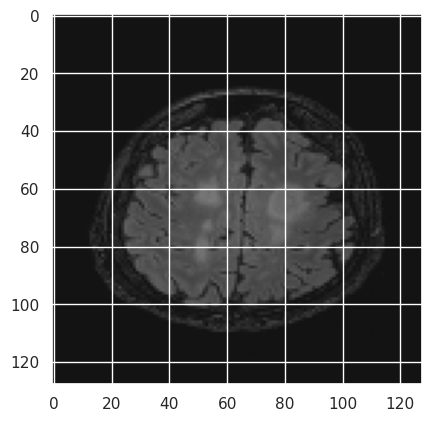

In [13]:
im=cv2.imread(f'..{sep}datasets{sep}refined{sep}test{sep}images{sep}MICCAI_Patient_0_e264.png')
plt.imshow(im)

In [14]:
#predict MICCAI
results = model.predict(source = f'..{sep}datasets{sep}refined{sep}train{sep}images',
                         save=True,
                         show=False,
                         imgsz=128,
                         conf=0.2,
                         save_txt = True)
#res = model(f'..{sep}datasets{sep}refined{sep}train{sep}images')
#plt.imshow(results)

Ultralytics YOLOv8.0.11 🚀 Python-3.9.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)
Fusing... 
YOLOv8l-seg summary: 295 layers, 45973568 parameters, 342800 gradients, 220.5 GFLOPs
Results saved to runs/detect/predict2
0 labels saved to runs/detect/predict2/labels
